In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [2]:
training_labels = pd.read_csv("set_entrenamiento.csv", low_memory=False)
labels_predict = pd.read_csv("trocafone_kaggle_test.csv", low_memory=False)
data = pd.read_csv("data_set.csv", low_memory = False)

In [3]:
training_labels = training_labels[['person','label']]
training_labels['label'].value_counts()

1    980
0    980
Name: label, dtype: int64

In [4]:
data.head()

,person,Direct,Email,Organic,Paid,Referral,Social,ad campaign hit,brand listing,checkout,...,mes_May,suma,promedio,maximo,minimo,Unnamed: 0,promedio de TFIdf modelo,Suma de TFidf modelo,Maximo de TFIdf modelo,Minimo de TFIdf modelo
0,0008ed71,2.0,0.0,0.0,0.0,0.0,0.0,0,0,3,...,6.0,121083102878903,2.018052e+13,20180517162837,20180517122747,0.0,1.617163,4.851488,1.859879,1.300103
1,00091926,1.0,0.0,25.0,0.0,0.0,0.0,15,25,2,...,448.0,9040871528715832,2.018052e+13,20180531195203,20180503220829,1.0,1.490856,557.580165,2.209395,1.000000
2,00091a7a,0.0,0.0,0.0,0.0,0.0,0.0,1,5,0,...,0.0,201803261454582,2.018033e+13,20180326145658,20180326145111,2.0,1.219303,3.657909,1.357806,1.000000
3,000ba417,0.0,0.0,6.0,0.0,0.0,0.0,1,24,6,...,206.0,4157187614421402,2.018052e+13,20180526130922,20180517111145,3.0,1.798317,287.730661,2.299973,1.000000
4,000c79fe,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,...,17.0,343068993055724,2.018053e+13,20180529003807,20180529002747,4.0,1.000000,4.000000,1.000000,1.000000


In [5]:
features = pd.merge(training_labels, data, on='person', how='inner')
features = features.fillna(0)
features['label'].value_counts()

1    980
0    980
Name: label, dtype: int64

In [6]:
labels = features['label']
features = features.drop(['label','person'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)
print("Train: ",len(x_train),"Test: ",len(x_test))

Train:  1470 Test:  490


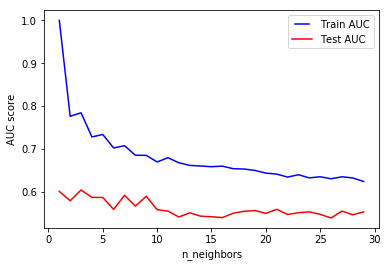

In [8]:
neighbors = list(range(1,30))
train_results = []
test_results = []
best = [0,1]
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    if best[0] < roc_auc:
            best[0] = roc_auc
            best[1] = n
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(neighbors, train_results, 'b', label='Train AUC')
line2, = plt.plot(neighbors, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.show()

In [9]:
max(test_results)

0.6049645390070921

In [10]:
best

[0.6049645390070921, 3]

In [12]:
set_test = pd.merge(data,labels_predict,on = "person", how = "right")
personas = set_test["person"]
set_test = set_test.drop(columns=['person'])

In [14]:
set_test = set_test.fillna(0)

In [15]:
model = KNeighborsClassifier(n_neighbors=best[1])
model.fit(x_train, y_train)
train_pred = model.predict(x_train)
y_pred = model.predict_proba(x_test)

preds_kaggel_knn = model.predict_proba(set_test)

In [16]:
df_kaggel_knn = pd.DataFrame(preds_kaggel_knn)
df_kaggel_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19415 entries, 0 to 19414
Data columns (total 2 columns):
0    19415 non-null float64
1    19415 non-null float64
dtypes: float64(2)
memory usage: 303.4 KB


In [17]:
df_kaggel_knn = pd.DataFrame(df_kaggel_knn[1])

In [18]:
df_kaggel_knn.head()

,1
0,0.666667
1,0.666667
2,1.000000
3,1.000000
4,0.333333


In [19]:
# df_kaggel_knn = df_kaggel_knn.to_frame()# df_kagg 
df_kaggel_knn["person"] = personas
df_kaggel_knn.rename(columns = {1: 'label'},inplace = True) 
df_kaggel_knn = df_kaggel_knn[['person','label']]

In [20]:
df_kaggel_knn.head()

,person,label
0,00091926,0.666667
1,00091a7a,0.666667
2,000ba417,1.000000
3,000e4d9e,1.000000
4,000e619d,0.333333


In [21]:
df_kaggel_knn.to_csv('ResultadosKNN.csv',index=False)